In [11]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *

from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os.path
import tweepy
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shefa\AppData\Roaming\nltk_data...


## Questions we are looking to answer about the Farmers Protest in India:
1) General sentiments of people - are they in favour of the Farm Bill or not - Classification. <br>
2) What are their main concerns - NER

## Dev Notes (for the group), delete this later
Regson (Preprocessing):
1) I only used the tweets which has not been truncated in the api - this means we are not actually working with 1000 tweets. We can increase max_items later to use more. <br>
2) I removed the all hashtags from tweets, but it might be useful keep them and just remove the "#" instead. The hash tag itself could hold some sentiment, this will need to be expiremented. <br>
3) I  removed stemmings, but im not sure how good this stemmings libaries is, we can give it a try with / without the stemming libiary and see what performs better? <br>
4) I removed the search terms "farmer" & "protest", because nearly every tweet contained this. <br>
5) I removed all non-ASCII text, this removed emojis and words written in hindi - I'm not sure if the sentiment libaries supports unicode but some emojis will definitely hold sentiment.  <br>

## Set up config information

In [4]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-4-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [13]:
USE_CSV = True

if not USE_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 1000
    result_type = "recent"
    lang = "en"
    # Do not include retweets or replies          
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets -filter:replies",
                             result_type=result_type, lang=lang).items(max_items)

    # Extract only the required keys from the response
    # Do not include truncated tweets
    tweets = [
        [tweet.created_at,
         tweet.text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified
        ] for tweet in response if (not tweet.truncated) ]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [40]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Truncated tweets were removed in the prior cell

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,:\\.!?|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert text to lower case
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too, we may need this 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove the search terms
'''
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('farmer', '', x))
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('protest', '', x))
'''
# Remove any hashtags
# (!) NOTE: it might be possible that someone uses hashtag in midtext, so might need this

tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))


# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
'''
min_word_length = 3
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))
'''
# Remove stemmings
# (?) NOTE: Maybe use a different stemming libary or keep stemmings
'''
stemmer = PorterStemmer()
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
'''
# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
#print(processed_tweets_df['text'].head())
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    can we have an investigation on this                                                                           
1    captain saab amarinder you need to investigate this police officers need to be punished                        
2    there is no compromise when it comes to injustice you have to fight it stand with our farmers\r\r \r\r 23 14 12
3    farmers in india are fighting for their livelihoods \r\r                                                       
4    with farmers 4farmers                                                                                          
Name: text_processed, dtype: object


 ## Word Cloud

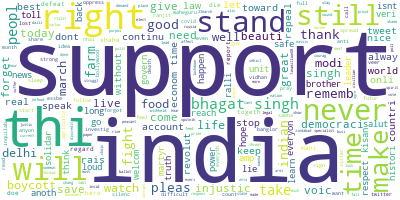

In [5]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

In [5]:
# tweets_df['text_processed'] is the processed text 
# tweets_df['text'] is the original tweet

## Sentiment Analysis

            created_at  \
0  2021-03-22 23:16:07   
1  2021-03-22 23:14:39   
2  2021-03-22 23:14:12   
3  2021-03-22 23:12:51   
4  2021-03-22 22:46:41   

                                                                                                                                      text  \
0  Can we have an investigation on this @SukhpalKhaira #FarmersProtest https://t.co/qe5ttozzPE                                               
1  Captain Saab @capt_amarinder You need to investigate this. Police officers need to be punished. #FarmersProtest https://t.co/qe5ttozzPE   
2  There is no compromise when it comes to injustice. You have to fight it.Stand with our farmers\n\n #FarmersProtest\n\n 23:14:12           
3  Farmers in India are fighting for their livelihoods. 🙏✊🏼\n#IStandWithFarmers\n#FarmersProtest https://t.co/RT8djhdopQ                     
4  What about COVID-19? Anyone?? #FarmersProtest #FarmersCallBJPboycott #23March_किसानों_के_साथ #kisanEktaMorcha https://t.co/LveF3qn

<AxesSubplot:title={'center':'sentiment analysis'}>

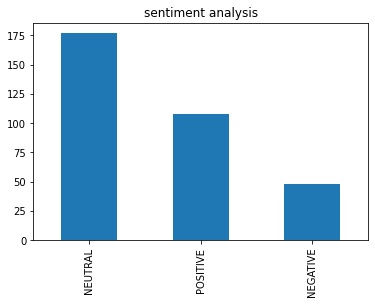

In [8]:
df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

sid = SentimentIntensityAnalyzer()

df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

print(df.head())
df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

# Named Entity Recognition

In [43]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
import spacy
import en_core_web_trf






2021-03-27 16:32:59.794772: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-03-27 16:32:59.795789: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [112]:
#nlp = spacy.load('en_core_web_sm')
unique_tweets = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8',header=None)


unique_tweets_list = list(tweets_df['text_processed'].values)

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  #print(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
#print(nlp.ents.label_) tweet_text[ne.start_char:ne.end_char]

 23 14 12:  99 101 CARDINAL 23 -- there is no compromise when it comes to injustice you have to fight it stand with our farmers
	NE found:  11 16 GPE india -- farmers in india are fighting for their livelihoods 
	NE found:  13 21 CARDINAL 4farmers -- with farmers 4farmers
	NE found:  17 19 CARDINAL 19 -- what about covid 19 anyone
 22 14 12against the injustice and oppression of farmers
	NE found:  0 5 GPE india -- india stand against crony capitalism
death toll 3007 CARDINAL 117 -- day 117
death toll 300 22 CARDINAL 300 -- day 117
	NE found:  22 31 CARDINAL 3/17/2021 -- farmers protest in dc 3/17/2021 we farm you eat
	NE found:  14 18 GPE nhai -- wondering how nhai makes annually from pan india tolls
	NE found:  25 33 DATE annually -- wondering how nhai makes annually from pan india tolls
	NE found:  43 48 GPE india -- wondering how nhai makes annually from pan india tolls
 NE found:  5 12 TIME evening -- good evening 
	NE found:  0 11 DATE another day -- another day another tweet abo

 05 14 12
	NE found:  40 52 DATE this weekend -- canada coming out with so many protests this weekend
	NE found:  61 66 GPE india -- innovative technologies at the helm of a digitally connected india economic times
farmer protest 248 civillians died
farmer protest 248 civillians died
	NE found:  29 34 GPE india -- account has been withheld in india in response to a legal demand learn more
